In [274]:
import glob
import pandas as pd
import re
import nltk
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import classification_report, confusion_matrix

nltk.download('stopwords')
nltk.download('wordnet')
np.random.seed(1000)

from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pierrelardet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pierrelardet/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Text Classification of Textbooks
### Pierre Lardet

This code is presented as a python notebook, using python 3.11.2. My thoughts are presented chronologically.

Versions of libraries used are listed below.  

- scikit-learn 1.2.2
- nltk 3.8.1
- pandas 2.0.0
- numpy 1.24.2


### Data Cleaning

Before anything else, we need to be able to read in the text and convert it into a format which is easy to manipulate. I'm going to use a [Pandas dataframe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html). I noticed that the Computer Science text files were nested in an extra directory so manually moved them to make the structure of text files consistent. Next, I read in all of the text files in an easily extensible manner, stored them in a 2d array labelled with their subject and created a new Pandas dataframe to make further manipulation easy.

In [3]:
subjects = ['Computer_Science', 'History', 'Maths']
raw_texts = []

def read_subject_data(subject:str)->None:
    for dir in glob.glob(f'./data/{subject}/*.txt'):
        f = open(dir, 'r')
        text = f.read()
        raw_texts.append([subject, text, dir])
        f.close()

for subject in subjects:
    read_subject_data(subject)

In [4]:
textbooks = pd.DataFrame(raw_texts, columns=['subject', 'text' ,'dir'])

textbooks = textbooks[textbooks['text'] != '']

print('-'*50)
print(f'Sample of the data: \n {textbooks.head()}')
print('-'*50)
print(f'Dimensions: {textbooks.shape}')
print('-'*50)
print(f'Counts of each subject: \n {textbooks.groupby("subject").count()}')
print('-'*50)



--------------------------------------------------
Sample of the data: 
             subject                                               text   
0  Computer_Science  4.8 Exercises 275\n4.15 [IS) <§§4.2, 4.3> One ...  \
1  Computer_Science  4.5 Fallacies and Pitfalls 26.\nFirst we find ...   
2  Computer_Science  518 Chapter 7 Large and Fast: Exploiting Memor...   
3  Computer_Science  Computers\nReconstructing the\nin the\nAncient...   
4  Computer_Science  230 Chapter 3 Arithmetic: for Computers\n3.9 [...   

                                               dir  
0  ./data/Computer_Science/Computer_Science291.txt  
1  ./data/Computer_Science/Computer_Science285.txt  
2  ./data/Computer_Science/Computer_Science534.txt  
3  ./data/Computer_Science/Computer_Science252.txt  
4  ./data/Computer_Science/Computer_Science246.txt  
--------------------------------------------------
Dimensions: (1341, 3)
--------------------------------------------------
Counts of each subject: 
               

Now we have a dataframe to work with. The text is currently very messy with lots of extra characters and spacing etc. In order to use the text as an input into a ML classification model, it needs to be much cleaner. The desired format will be a list of lower-case words in each sample which can later be converted to numeric values.

In [64]:
stopwords = nltk.corpus.stopwords.words('english')
lem = WordNetLemmatizer()
in_stopwords = lambda word: word not in stopwords

def clean_text(str:str) -> str:
    str = re.sub(r'\n', ' ', str) # Replace new lines and spaces
    str = re.sub(r'[^a-zA-Z]+', ' ', str) # Retain only alphabetic characters
    str = str.lower()

    lst_words = str.split(' ')

    lst_words = list(filter(in_stopwords, lst_words)) # Remove stopwords from nltk corpus
    lst_words = [lem.lemmatize(word) for word in lst_words] # Lemmatize all words

    return ' '.join(lst_words)

textbooks['text_clean'] = textbooks['text'].apply(clean_text)

print(textbooks.head())

            subject                                               text   
0  Computer_Science  4.8 Exercises 275\n4.15 [IS) <§§4.2, 4.3> One ...  \
1  Computer_Science  4.5 Fallacies and Pitfalls 26.\nFirst we find ...   
2  Computer_Science  518 Chapter 7 Large and Fast: Exploiting Memor...   
3  Computer_Science  Computers\nReconstructing the\nin the\nAncient...   
4  Computer_Science  230 Chapter 3 Arithmetic: for Computers\n3.9 [...   

                                               dir   
0  ./data/Computer_Science/Computer_Science291.txt  \
1  ./data/Computer_Science/Computer_Science285.txt   
2  ./data/Computer_Science/Computer_Science534.txt   
3  ./data/Computer_Science/Computer_Science252.txt   
4  ./data/Computer_Science/Computer_Science246.txt   

                                          text_clean  
0   exercise one user told three program exercise...  
1   fallacy pitfall first find execution time two...  
2   chapter large fast exploiting memory hierarch...  
3  compute

### Feature Engineering

We now have clean text and can engineer these into ML features. I'm going to use the Tfidf class from scikit-learn. I'm also going to split the data into training and test data with 30% being reserved for testing.

In [269]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(textbooks['text_clean'], textbooks['subject'], test_size=0.3, random_state=4)

encoder = LabelEncoder()
train_y = encoder.fit_transform(train_y)
test_y = encoder.transform(test_y)

Tfidf_vect = TfidfVectorizer()
tfidf_train_x = Tfidf_vect.fit_transform(train_x)
tfidf_test_x = Tfidf_vect.transform(test_x)
print(tfidf_train_x.shape[1])


['Computer_Science' 'History' 'Maths']
22466


### ML Classification Model

Finally, we can bring in an ML classification model and train it on the data.

In [281]:
SVM = svm.SVC(C=10.0, kernel='linear', random_state=0).fit(tfidf_train_x, train_y)



### Evluation

In [282]:
predictions = SVM.predict(tfidf_test_x)
print(classification_report(test_y, predictions, labels=[0,1,2], target_names=encoder.classes_))
print(confusion_matrix(test_y, predictions, labels=[0,1,2]))
print(len(SVM.coef_.getrow(0).toarray()[0]))

print(SVM.predict(Tfidf_vect.transform(['fraction'])))

                  precision    recall  f1-score   support

Computer_Science       1.00      0.99      0.99       192
         History       0.99      1.00      0.99       148
           Maths       1.00      1.00      1.00        63

        accuracy                           1.00       403
       macro avg       1.00      1.00      1.00       403
    weighted avg       1.00      1.00      1.00       403

[[190   2   0]
 [  0 148   0]
 [  0   0  63]]
22466
[2]


### Improvements

In [ ]:
selector = SelectKBest(chi2, k = 20000)
selected_train_x = selector.fit_transform(tfidf_train_x, train_y)
selected_test_x = selector.transform(tfidf_test_x)

### Extensions

Since the SVM kernel is linear, the coefficients for each feature can easily be extracted and the features with the greatest effect on the classifier's choice of class can be visualised. This data, and the plots generated, do a great deal of work in explicability of the model. 

Sklearn's SVM implementation works by a series of binary classifications and generates a coefficient array for each possible combination of classes. Fortunately there are only 3 classes in this case, so I have mapped each coefficient array to its relevant binary classification decision and plotted the 20 words with the greatest effect on the outcome on either side of each combination.

Code for plotting was copied from https://aneesha.medium.com/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d and adapted for mutliclass classification and for nicer plots.

The results are somewhat unsurprising but interesting to see what words SVM has picked out as the most important from this dataset. A particular example I liked was that the word 'state' is the most important word in the Maths vs History classification for determining that a sample is 'History', but in History vs Computer Science, 'state' is less important. This makes sense because the word 'state' may appear in some instances to reference memory state or some other computer science concept of state.

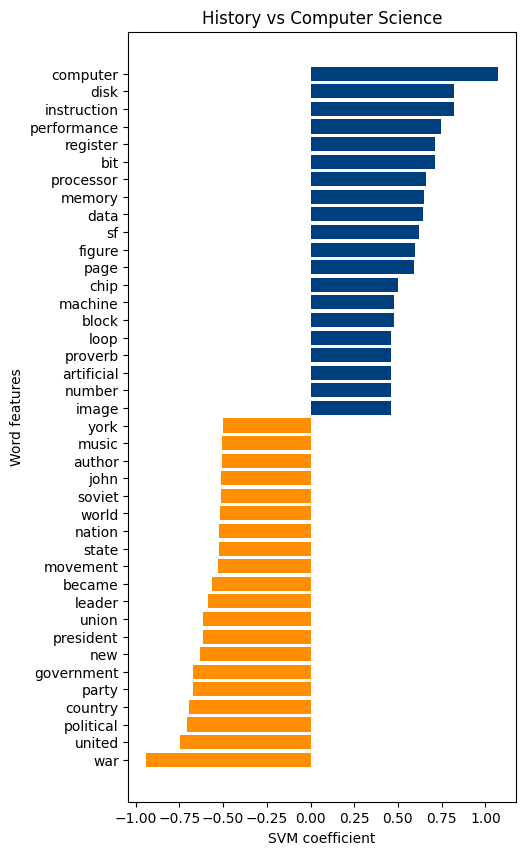

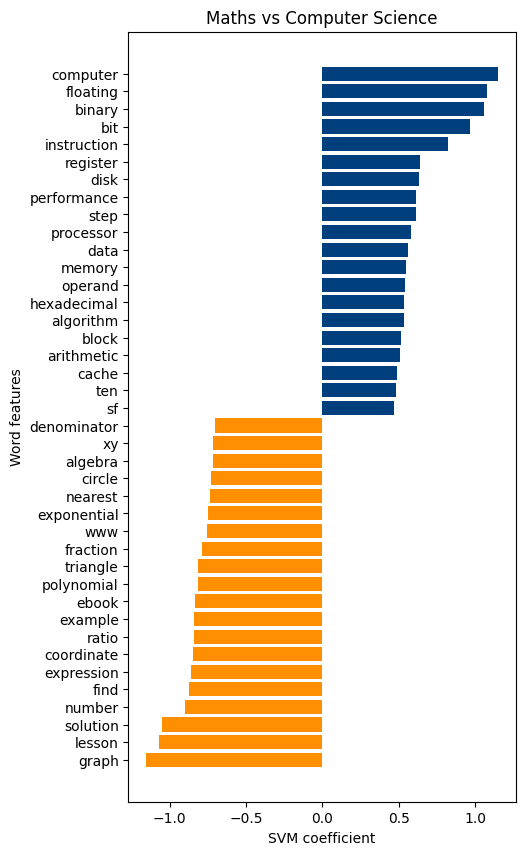

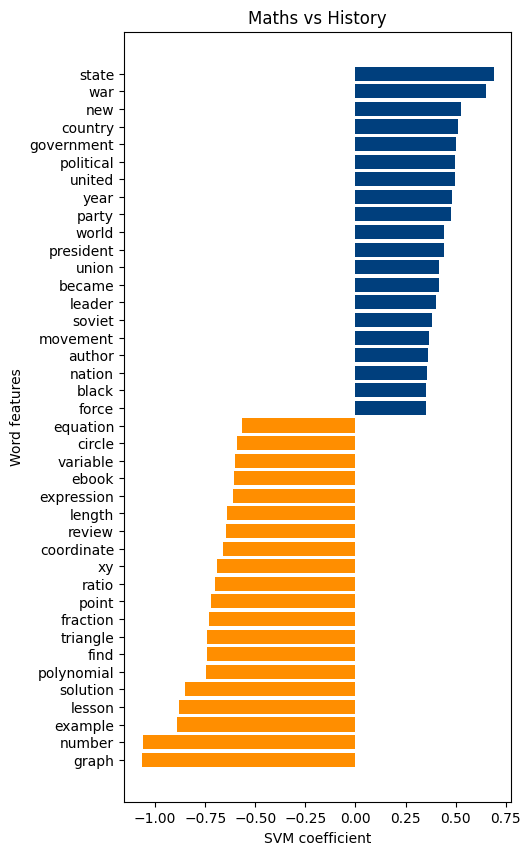

In [310]:
import matplotlib.pyplot as plt

def plot_coefficients(coef:np.ndarray, feature_names:np.ndarray, title:str, top_features=20):
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    plt.figure(figsize=(5, 10))
    plt.title(title)
    plt.ylabel('Word features')
    plt.xlabel('SVM coefficient')
    colors = ['#ff8e00' if c < 0 else '#003f7d' for c in coef[top_coefficients]]
    plt.barh(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.yticks(np.arange(0, 2 * top_features), feature_names[top_coefficients])
    plt.show()

# SVM computes coefficients for each possible combination of classes using this order according to https://stackoverflow.com/questions/35170805/sklearn-svm-coefficient-attribute-how-to-get-class-name
comparisons = {
 0: 'History vs Computer Science',
 1: 'Maths vs Computer Science',
 2: 'Maths vs History',
}

for row in [0,1,2]:
 plot_coefficients(SVM.coef_.getrow(row).toarray()[0], Tfidf_vect.get_feature_names_out(), comparisons[row])